In [ ]:
# Autoreload packages in case they change.
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import btk
import btk.plot_utils
import ipywidgets as widgets
import matplotlib.patches as patches
import pandas as pd
import seaborn as sns
from IPython.display import clear_output, display

# Changing fonts to be latex typesetting
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'dejavuserif'
rcParams['font.family'] = 'serif'

Changing the `plot_metrics_summary` code to allow for more descriptive titles of the different detection algorithms, as well as, taking out the upper title that is usually printed when `eff_mat` is selected in the interactive mode. 

In [ ]:
class BrightDefaultSampling(btk.sampling_functions.SamplingFunction):
    """Default sampling function used for producing blend tables with an explicit mag cut."""

    def __init__(self, max_number=2, mag_cut=20, stamp_size=24.0, max_shift=None):
        """
        Args:
            max_number (int): Defined in parent class
            stamp_size (float): Size of the desired stamp.
            max_shift (float): Magnitude of maximum value of shift. If None then it
                             is set as one-tenth the stamp size. (in arcseconds)
            mag_cut (float): The maximum magnitude that the samples can go to.
        """
        super().__init__(max_number)
        self.stamp_size = stamp_size
        self.max_shift = max_shift if max_shift else self.stamp_size / 10.0
        self.mag_cut = mag_cut

    @property
    def compatible_catalogs(self):
        return "CatsimCatalog", "CosmosCatalog"

    def __call__(self, table):
        """Applies default sampling to the input CatSim-like catalog and returns an
        astropy table with entries corresponding to a blend centered close to postage
        stamp center.

        Function selects entries from input table that are brighter than 25.3 mag
        in the i band. Number of objects per blend is set at a random integer
        between 1 and Args.max_number. The blend table is then randomly sampled
        entries from the table after selection cuts. The centers are randomly
        distributed within 1/10th of the stamp size. Here even though the galaxies
        are sampled from a CatSim catalog, their spatial location are not
        representative of real blends.

        Args:
            table (astropy.table): Table containing entries corresponding to galaxies
                                   from which to sample.

        Returns:
            Astropy.table with entries corresponding to one blend.
        """
        number_of_objects = np.random.randint(1, self.max_number + 1)
        (q,) = np.where(table["ref_mag"] <= self.mag_cut)

        blend_table = table[np.random.choice(q, size=number_of_objects)]
        blend_table["ra"] = 0.0
        blend_table["dec"] = 0.0
        x_peak, y_peak = _get_random_center_shift(number_of_objects, self.max_shift)
        blend_table["ra"] += x_peak
        blend_table["dec"] += y_peak

        if np.any(blend_table["ra"] > self.stamp_size / 2.0) or np.any(
            blend_table["dec"] > self.stamp_size / 2.0
        ):
            warnings.warn("Object center lies outside the stamp")
        return blend_table
    

def _get_random_center_shift(num_objects, max_shift):
    """Returns random shifts in x and y coordinates between + and - max-shift in arcseconds.

    Args:
        num_objects (int): Number of x and y shifts to return.

    Returns:
        x_peak (float): random shift along the x axis
        y_peak (float): random shift along the x axis
    """
    x_peak = np.random.uniform(-max_shift, max_shift, size=num_objects)
    y_peak = np.random.uniform(-max_shift, max_shift, size=num_objects)
    return x_peak, y_peak

`max_shift` plays an important role in the efficiency matrix. `max_shift=5` gives poor results, but `max_shift=10` helps produce more sensible results.

In [ ]:
# Define parameters
stamp_size = 25.6 #Original: 24
seed = 42
max_number = 6
max_shift = 5.0 # 10 had good results # Original: None

# Import the galaxy catalog
catalog_name = "/Users/matt/Desktop/UCI_Research/LSST/btk_blending/btk_tutorial/data/OneDegSq.fits"
catalog = btk.catalog.CatsimCatalog.from_file(catalog_name)

# Choose the sampling function
# sampling_function = btk.sampling_functions.DefaultSampling(stamp_size=stamp_size,
#                                                            max_number=max_number,
#                                                            seed=seed)
sampling_function = BrightDefaultSampling(stamp_size=stamp_size,
                                          mag_cut=20,
                                          max_number=max_number,
                                          max_shift=max_shift)
# Load teh survey parameters
survey = btk.survey.get_surveys("LSST")

# Instantiate the image generator
draw_blend_generator = btk.draw_blends.CatsimGenerator(
    catalog,
    sampling_function,
    [survey],
    stamp_size=stamp_size,
    batch_size=100, #,
    augment_data=True,
    seed=seed)

meas_generator = btk.measure.MeasureGenerator([btk.measure.sep_singleband_measure,btk.measure.basic_measure],
                                              draw_blend_generator)

metrics_generator = btk.metrics.MetricsGenerator(meas_generator,
                                                 target_meas={"ellipticity":btk.metrics.meas_ksb_ellipticity}, #See custom-tutorial for more details
                                                 meas_band_name="r")
blend_results, meas_results,results = next(metrics_generator)


Generating blends for LSST survey:   0%|          | 0/100 [00:00<?, ?it/s]

Generating blends for LSST survey:   0%|          | 0/100 [00:00<?, ?it/s]

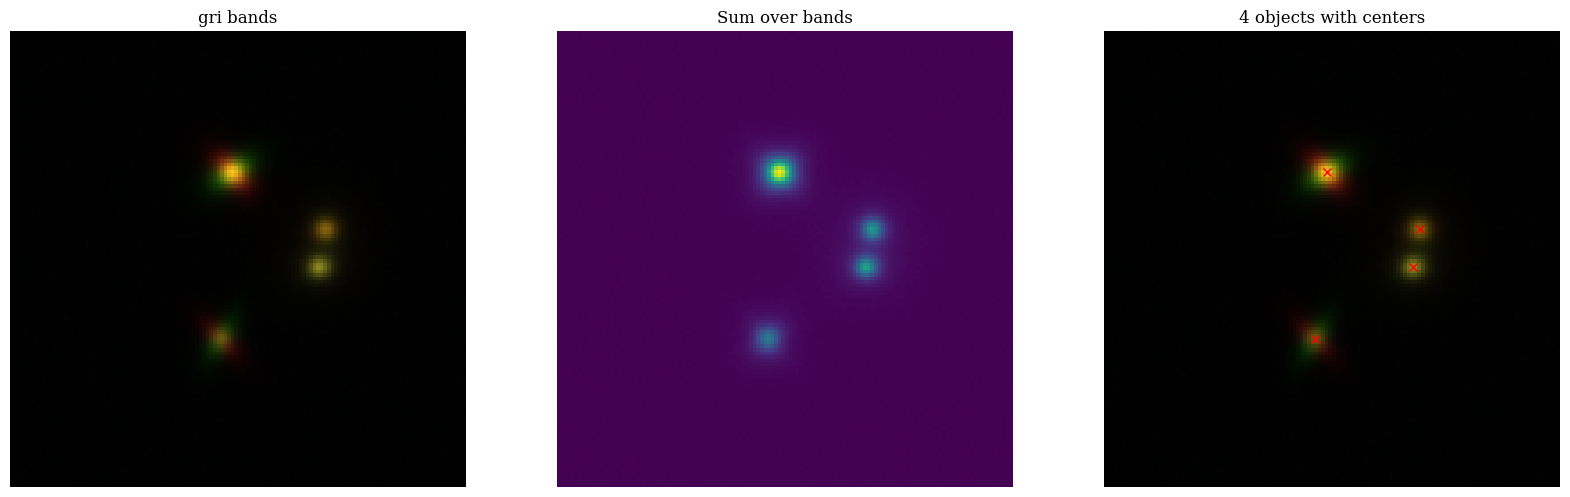

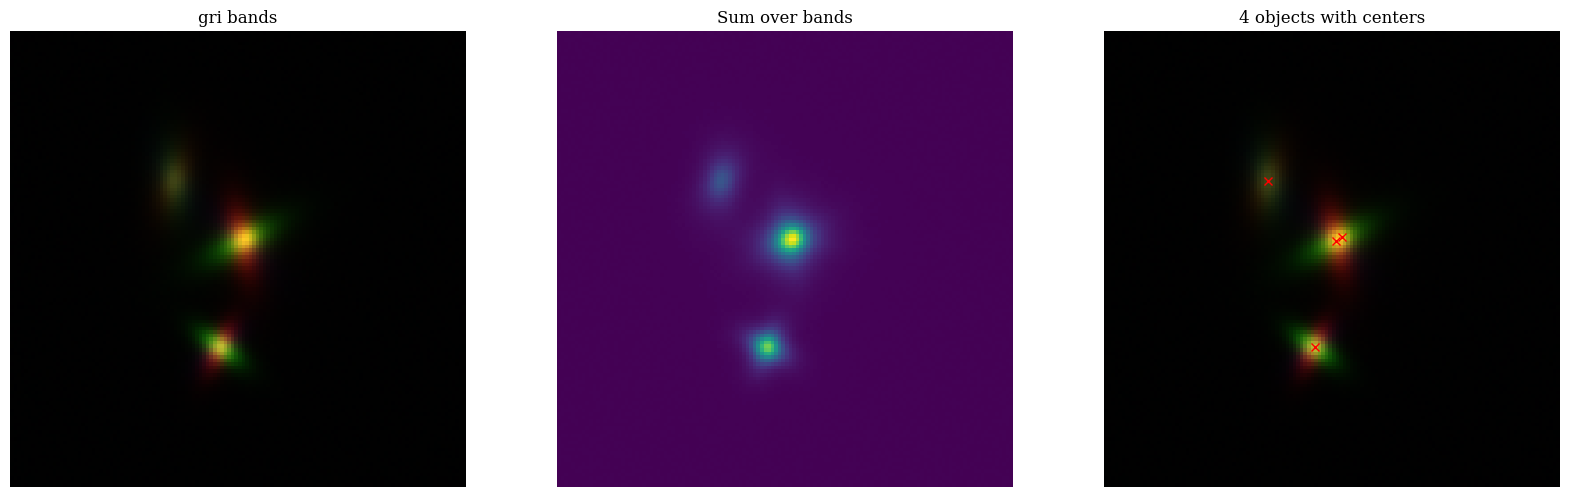

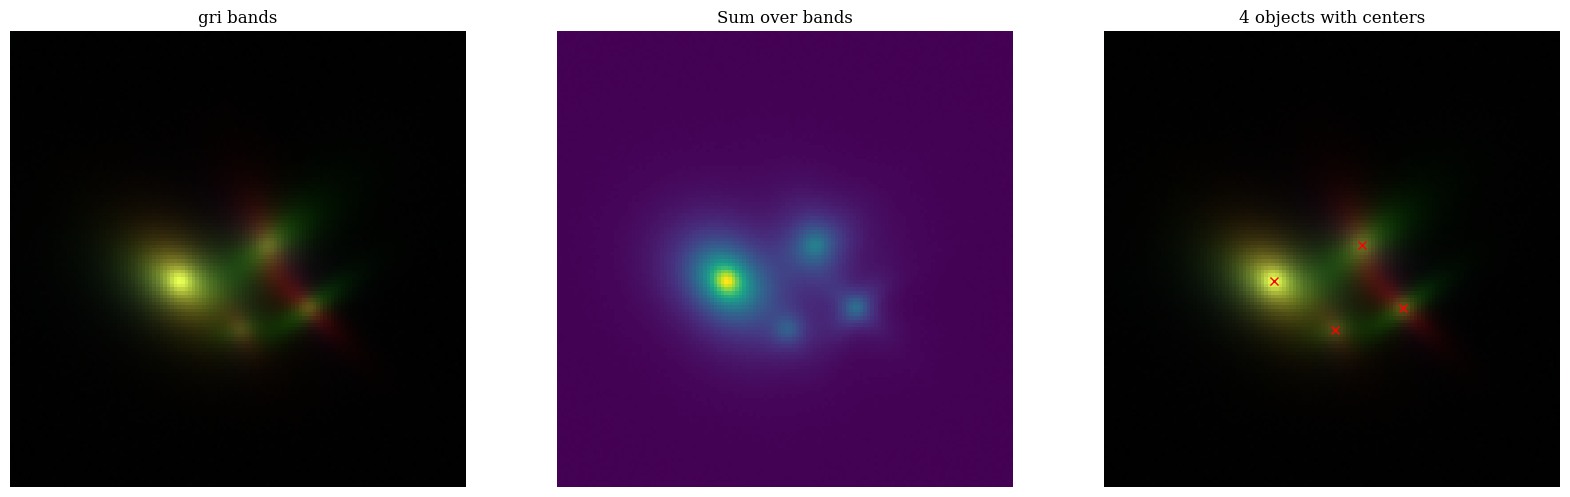

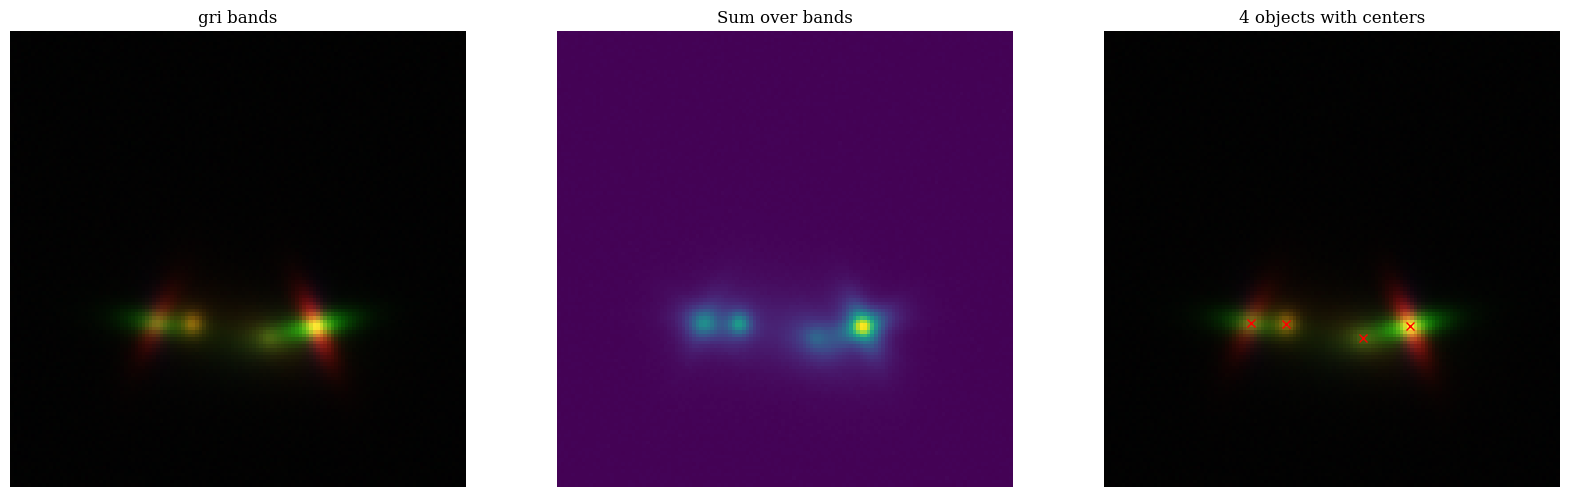

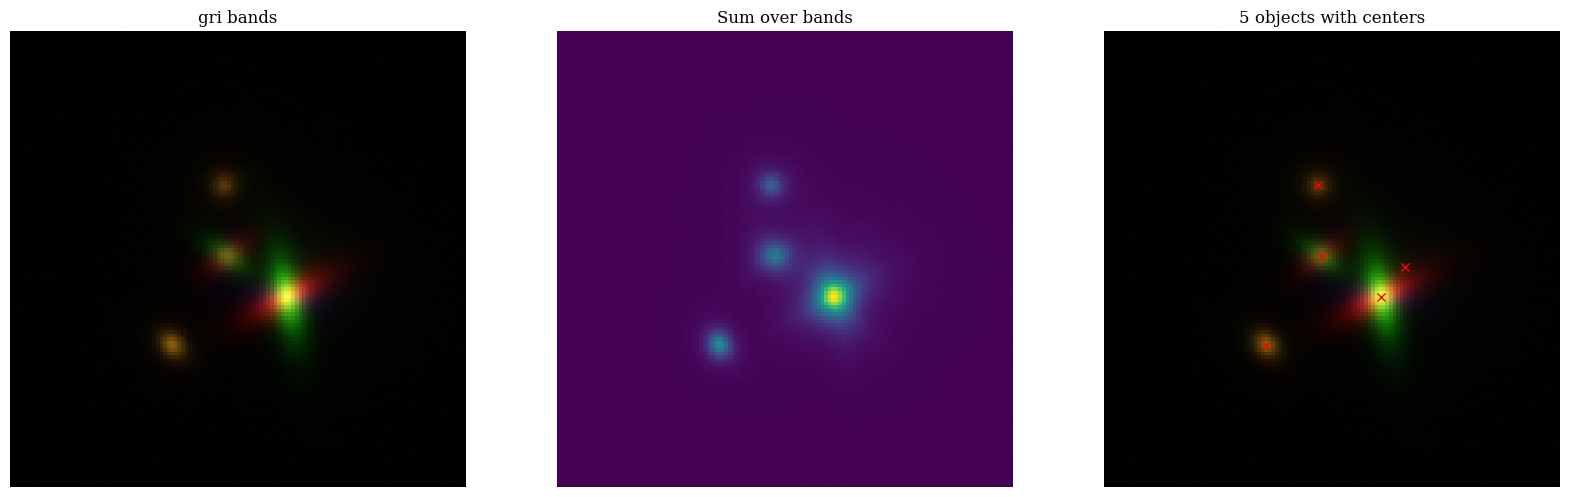

In [ ]:
batch = next(draw_blend_generator)
blend_images = batch['blend_images']
blend_list = batch['blend_list']
btk.plot_utils.plot_blends(blend_images[:5], blend_list[:5], norm="asinh", Q=0.1)

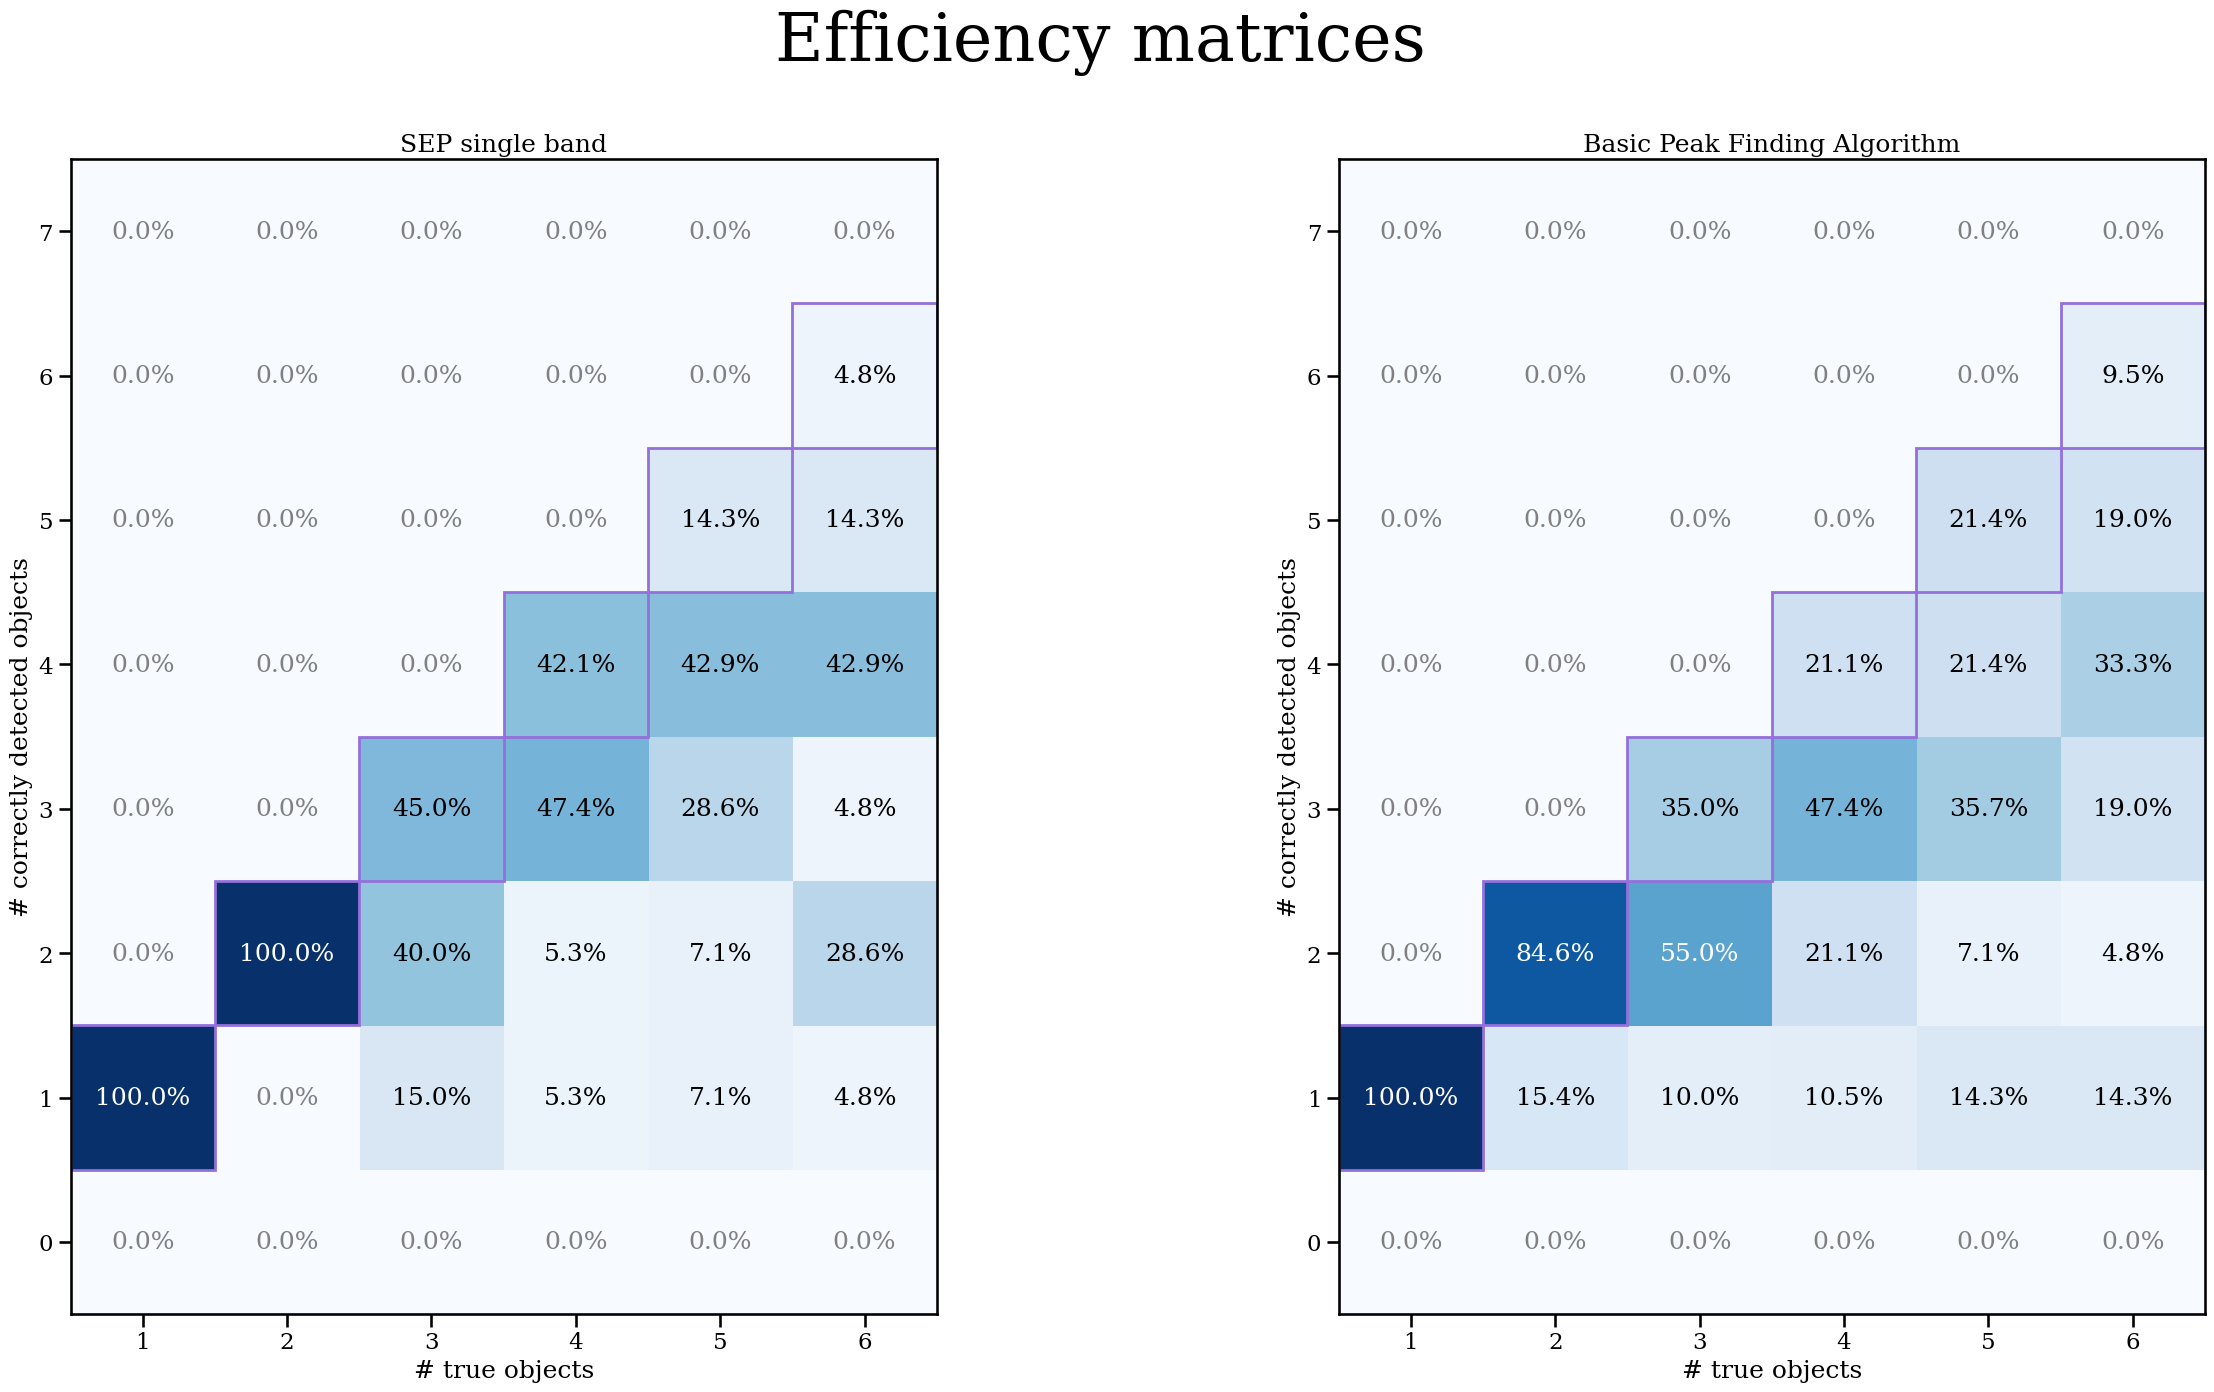

In [ ]:
btk.plot_utils.plot_metrics_summary(results,
                                    interactive=True,
                                    target_meas_keys=['ellipticity0'],
                                    target_meas_limits=[(-1, 1)],
                                    aliases = {'sep_singleband_measure': "SEP single band",
                                               'basic_measure': "Basic Peak Finding Algorithm"},
                                    save_path='/Users/matt/Downloads')

Generating blends for LSST survey:   0%|          | 0/100 [00:00<?, ?it/s]

Generating blends for LSST survey:   0%|          | 0/100 [00:00<?, ?it/s]

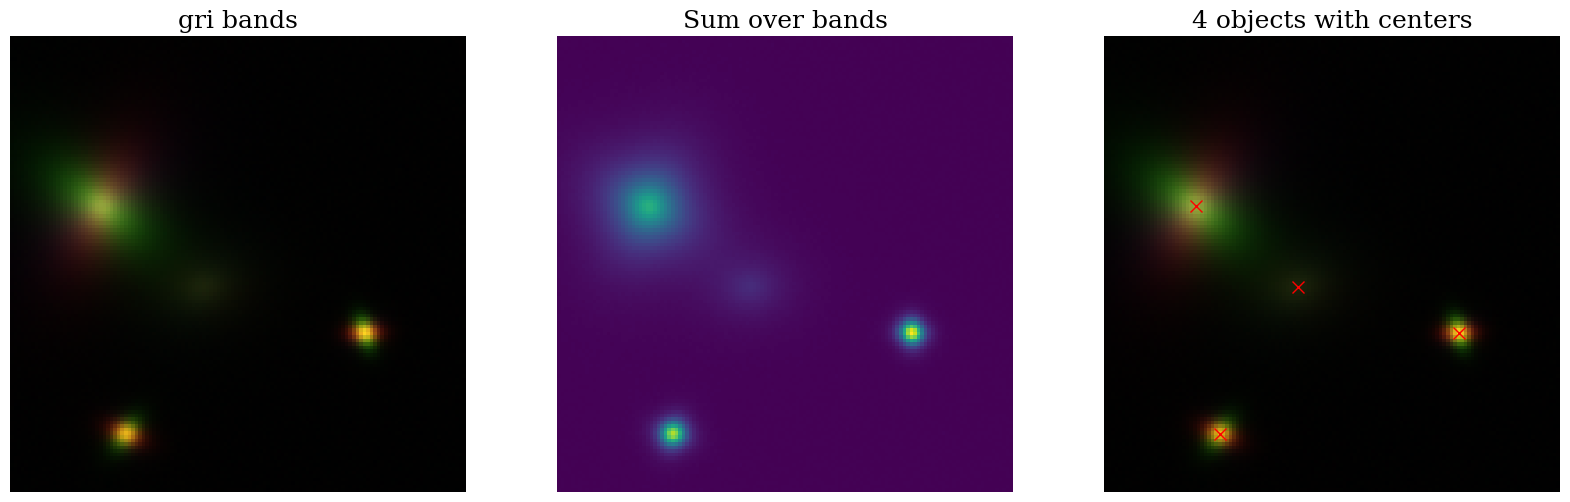

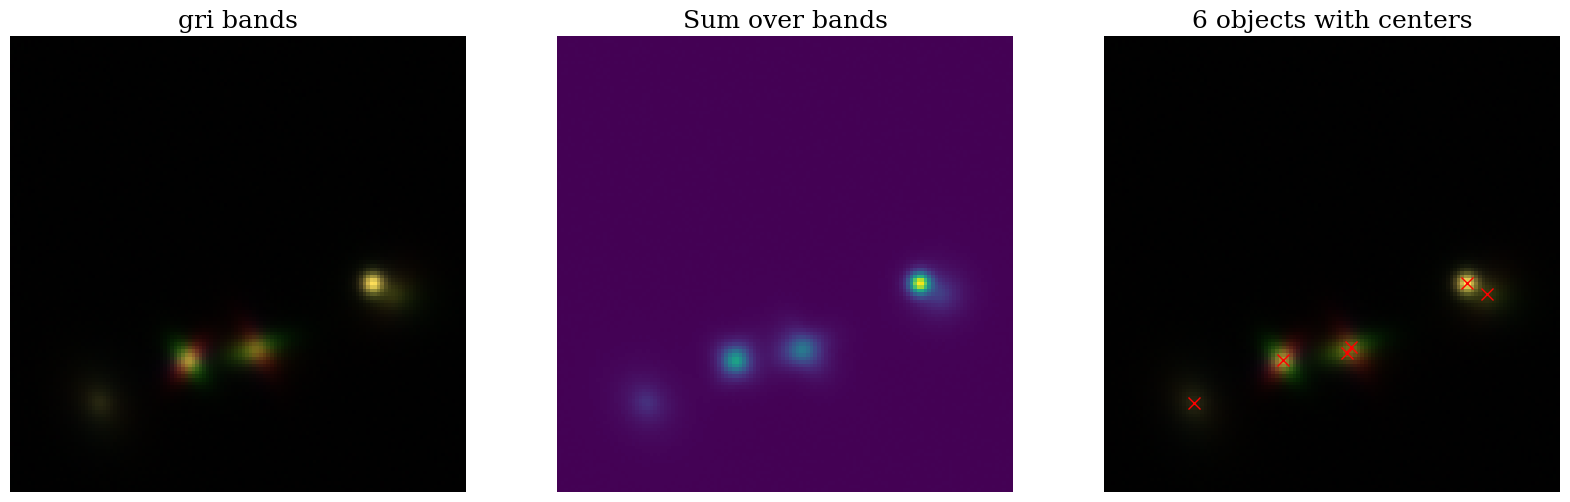

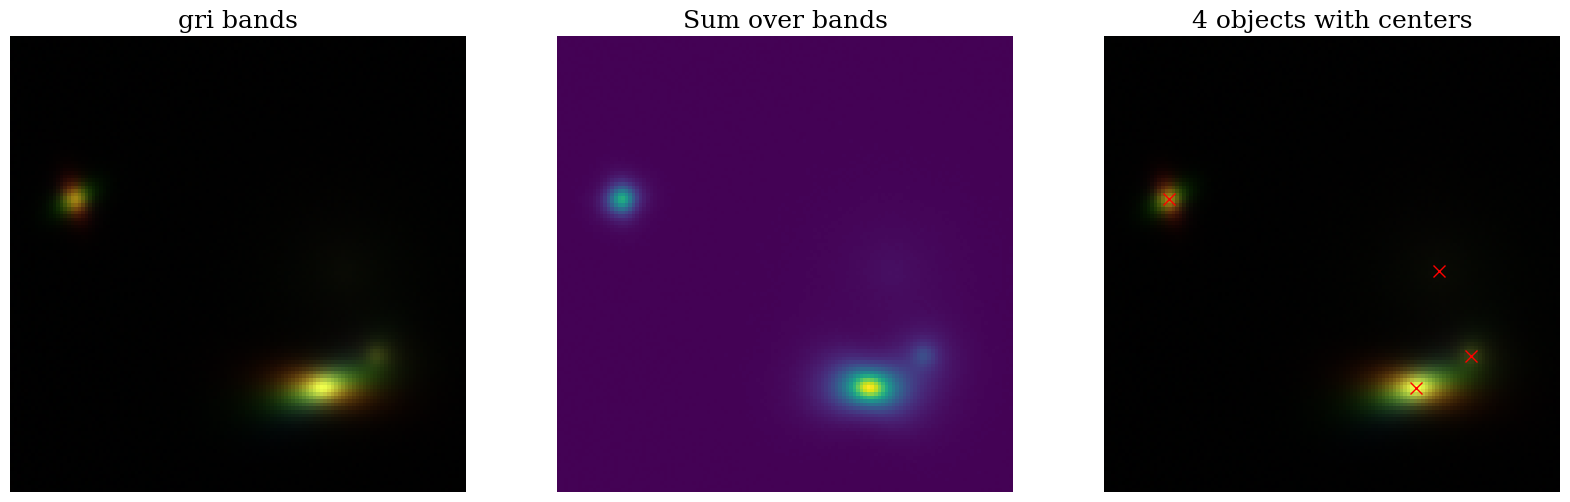

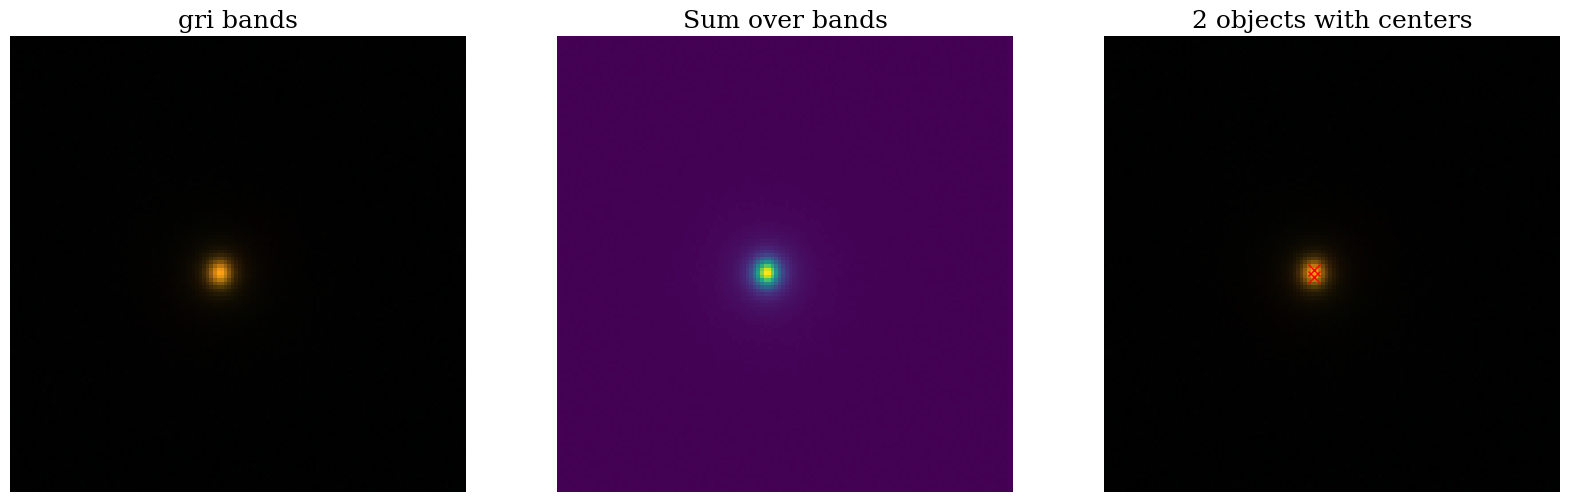

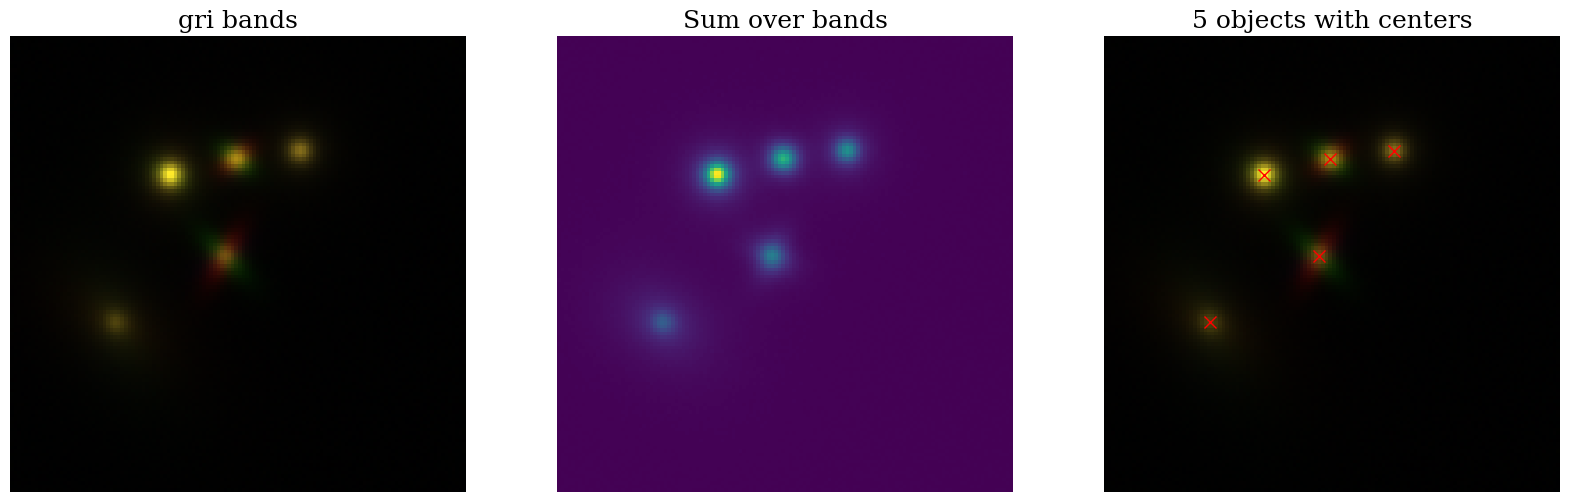

In [ ]:
# Define parameters
stamp_size = 25.6 #Original: 24
seed = 42
max_number = 6
max_shift = 10.0 # 10 had good results # Original: None

# Import the galaxy catalog
catalog_name = "/Users/matt/Desktop/UCI_Research/LSST/btk_blending/btk_tutorial/data/OneDegSq.fits"
catalog = btk.catalog.CatsimCatalog.from_file(catalog_name)

# Choose the sampling function
sampling_function = BrightDefaultSampling(stamp_size=stamp_size,
                                          mag_cut=20,
                                          max_number=max_number,
                                          max_shift=max_shift)
# Load teh survey parameters
survey = btk.survey.get_surveys("LSST")

# Instantiate the image generator
draw_blend_generator = btk.draw_blends.CatsimGenerator(
    catalog,
    sampling_function,
    [survey],
    stamp_size=stamp_size,
    batch_size=100, #,
    augment_data=True,
    seed=seed)

meas_generator = btk.measure.MeasureGenerator([btk.measure.sep_singleband_measure,btk.measure.basic_measure],
                                              draw_blend_generator)

metrics_generator = btk.metrics.MetricsGenerator(meas_generator,
                                                 target_meas={"ellipticity":btk.metrics.meas_ksb_ellipticity}, #See custom-tutorial for more details
                                                 meas_band_name="r")
blend_results, meas_results,results = next(metrics_generator)

batch = next(draw_blend_generator)
blend_images = batch['blend_images']
blend_list = batch['blend_list']
btk.plot_utils.plot_blends(blend_images[:5], blend_list[:5],norm="asinh", Q=0.1)


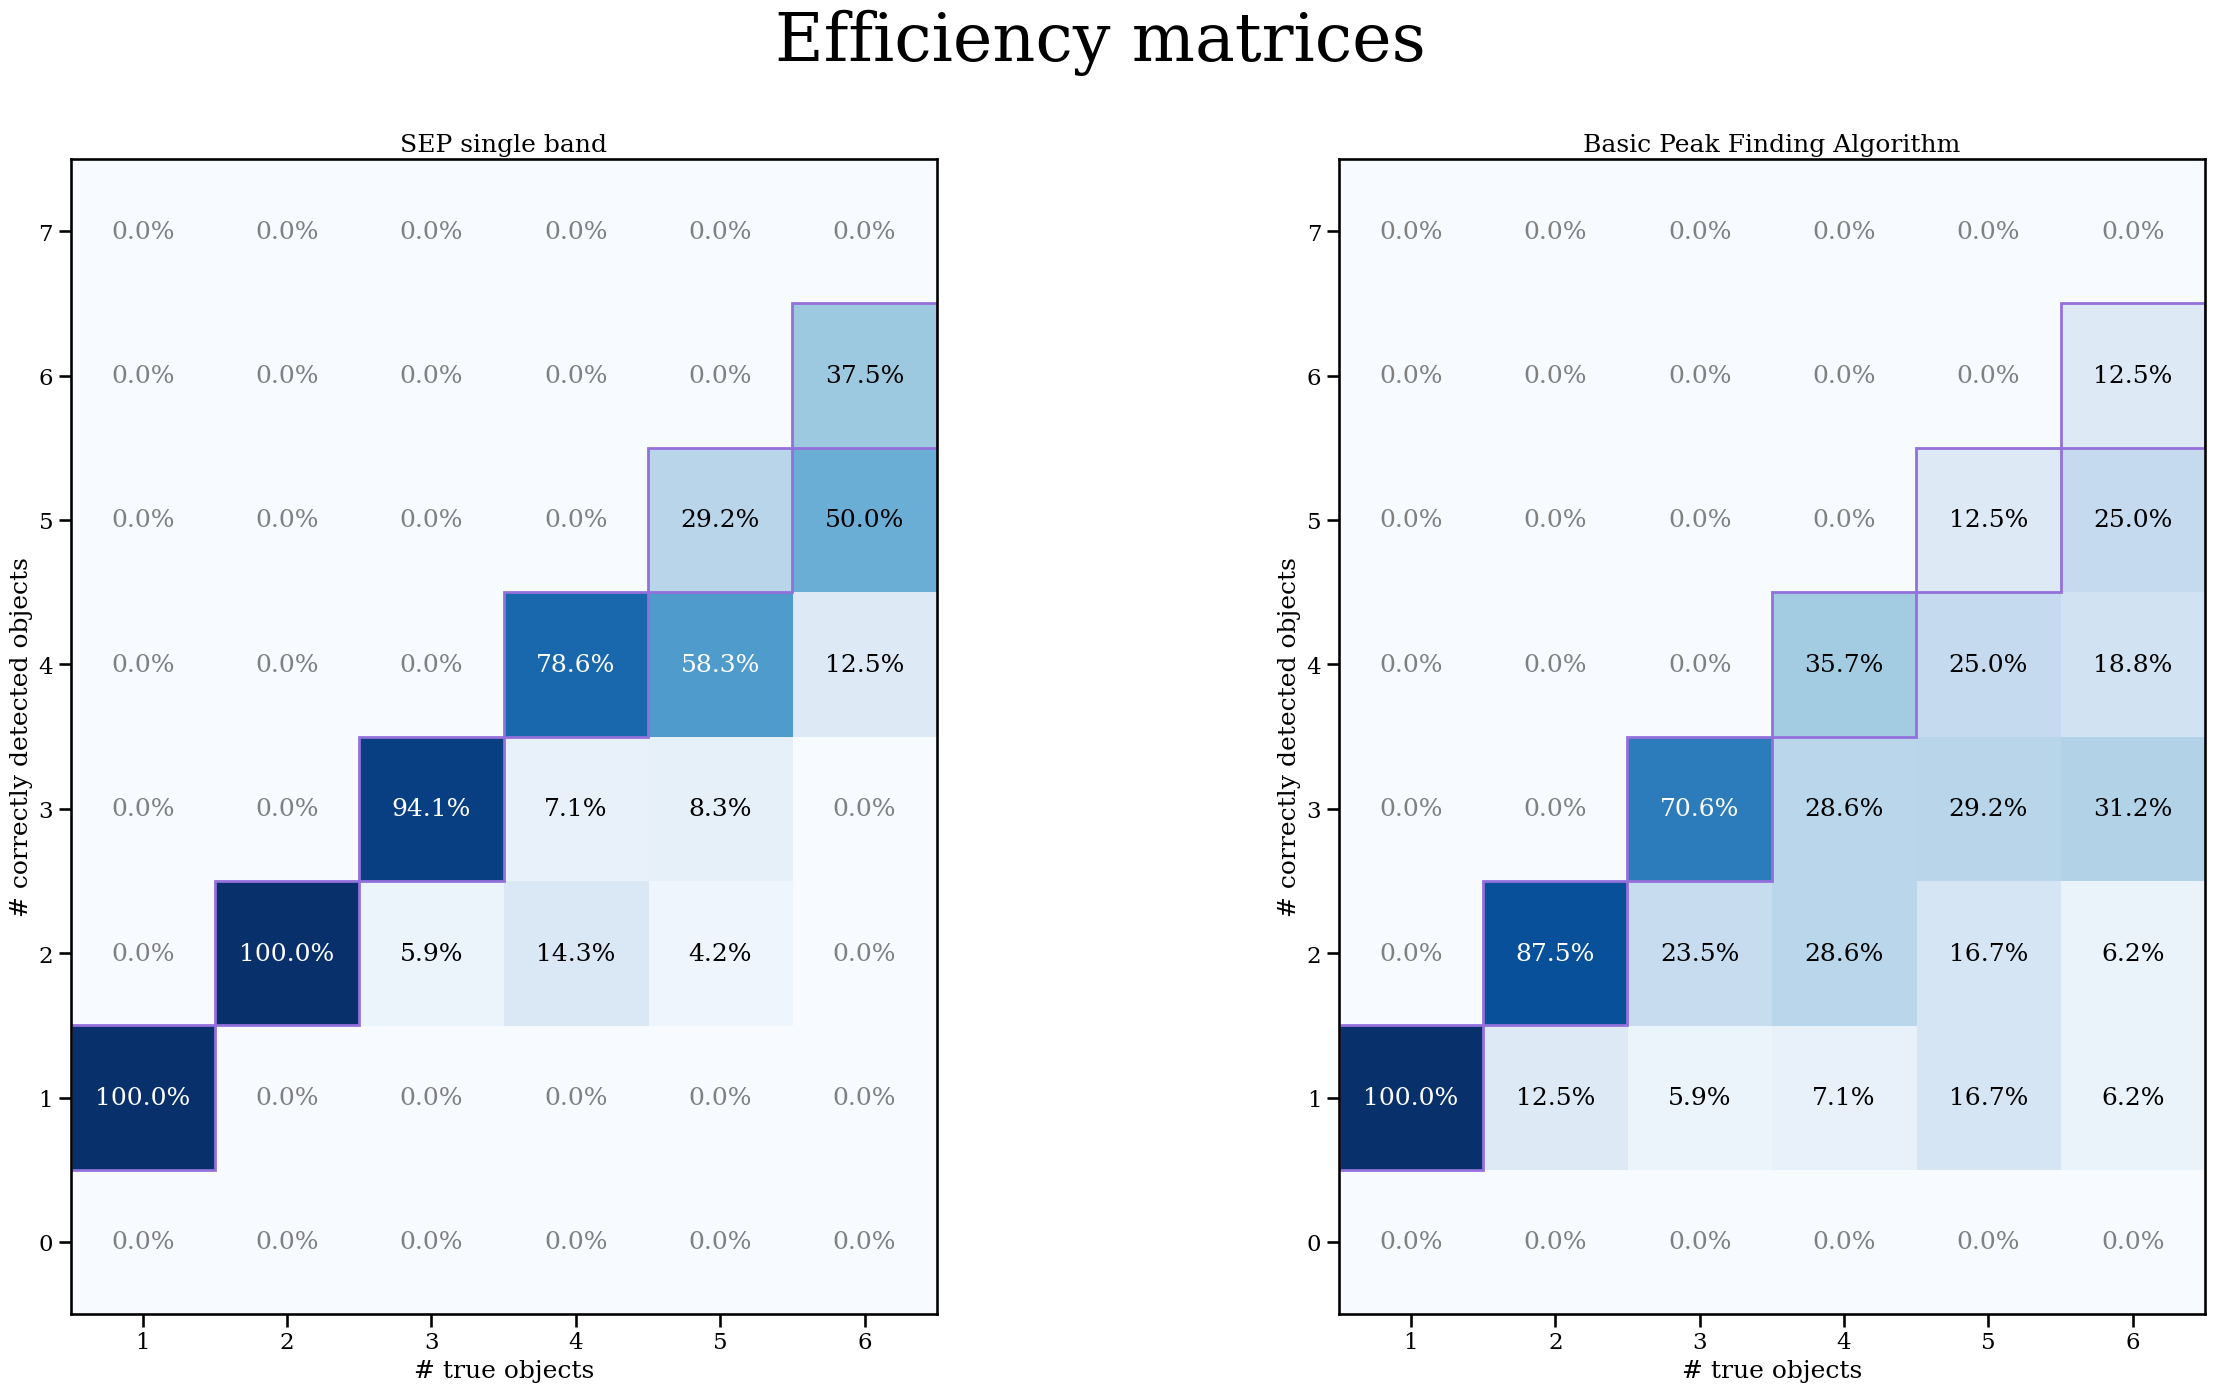

In [ ]:
btk.plot_utils.plot_metrics_summary(results,
                                    interactive=True,
                                    target_meas_keys=['ellipticity0'],
                                    target_meas_limits=[(-1, 1)],
                                    aliases = {'sep_singleband_measure': "SEP single band",
                                               'basic_measure': "Basic Peak Finding Algorithm"},
                                    save_path='/Users/matt/Downloads')

In [ ]:
batch['blend_list'][0]

galtileid,ra,dec,redshift,fluxnorm_bulge,fluxnorm_disk,fluxnorm_agn,a_b,a_d,b_b,b_d,pa_bulge,pa_disk,u_ab,g_ab,r_ab,i_ab,z_ab,y_ab,ref_mag,btk_size,x_peak,y_peak,btk_rotation,not_drawn_u,not_drawn_g,not_drawn_r,not_drawn_i,not_drawn_z,not_drawn_y
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2200003475,-0.22034026879891755,3.715048857724529,0.169879794121,3.27200505426e-15,3.40267097721e-17,0.0,2.34155321121,4.65513324738,2.05689549446,2.41241812706,24.393033208363363,24.393033208363363,20.5528907776,18.9909725189,17.9930801392,17.5455036163,17.290189743,17.1231613159,17.5455036163,4.050973296029169,62.39829865600246,82.0752442906213,286.1959096892272,0.0,0.0,0.0,0.0,0.0,0.0
2200035313,-0.2488886093996623,-2.9462379725601124,0.418224185705,6.86034483294e-17,4.35375808391e-16,0.0,0.334215402603,1.96994113922,0.277428388596,1.33630275726,110.87288574054804,110.87288574054804,21.2501678467,20.849199295,19.9477119446,19.6285190582,19.4232139587,19.3019771576,19.6285190582,8.534176816223892,62.25555695299341,48.76881013603288,258.952014770258,0.0,0.0,0.0,0.0,0.0,0.0
2200029150,-3.519916501681646,-4.882548065965755,0.198411896825,3.95039411229e-16,6.84918186514e-17,0.0,0.86801892519,0.166110306978,0.815940320492,0.0363744981587,193.05188354069514,193.05188354069514,22.5137405396,20.9128608704,19.8094615936,19.3415222168,19.0681056976,18.862909317,19.3415222168,1.2071832375979095,45.90041748984696,39.08725966194318,201.6386489606825,0.0,0.0,0.0,0.0,0.0,0.0
2200038184,5.363123533611034,-2.3928331835150036,0.305160492659,6.18182909054e-16,0.0,5.3496331165e-17,0.668953716755,0.0,0.667740106583,0.0,69.35983052799867,87.41637959999873,23.1881942749,21.4370803833,20.1583366394,19.5906066895,19.310338974,19.1028804779,19.5906066895,0.9766724264623,90.31561767424171,51.535834077716835,74.56939659999979,0.0,0.0,0.0,0.0,0.0,0.0
